<a href="https://colab.research.google.com/github/AnikBarua007/hqcnn_model/blob/main/HQCNN_ANIK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit qiskit-aer imbalanced-learn scikit-learn
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=675216c1398d1590bc971e760c39ed1008ce2c2eaaa36b9ee12f479abd609e0b
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


In [2]:
!pip install qiskit qiskit-aer

In [3]:
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator, Aer
from imblearn.over_sampling import ADASYN
from google.colab import drive
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, classification_report


Counts: {'1': 100}


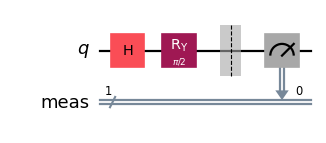

In [5]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator, Aer

class MyQuantumCircuit:
    def __init__(self, n_qubits, backend, shots):
        self.n_qubits = n_qubits
        self.backend = backend
        self.shots = shots

        self.circuit = QuantumCircuit(n_qubits)
        self.theta = Parameter("theta")
        self.circuit.h(0)
        self.circuit.ry(self.theta, 0)
        self.circuit.measure_all()

    def run(self, theta):
        if isinstance(theta, (list, np.ndarray)):
            theta = theta[0]

        circuit = QuantumCircuit(self.n_qubits)
        circuit.h(0)
        circuit.ry(theta, 0)
        circuit.measure_all()

        transpiled_circuit = transpile(circuit, self.backend)

        job = self.backend.run(transpiled_circuit, shots=self.shots)
        result = job.result()
        counts = result.get_counts()

        counts_array = np.array(list(counts.values()))
        states_array = np.array([int(state, 2) for state in counts.keys()])
        probabilities = counts_array / self.shots
        expectation = np.sum(states_array * probabilities)

        return np.array([expectation])

    def draw_circuit(self, theta):
        circuit = QuantumCircuit(self.n_qubits)
        circuit.h(0)
        circuit.ry(theta, 0)
        circuit.measure_all()
        transpiled_circuit = transpile(circuit, AerSimulator())

        job = AerSimulator().run(transpiled_circuit, shots=100)
        result = job.result()
        counts = result.get_counts(transpiled_circuit)
        print("Counts:", counts)

        figure = circuit.draw(output='mpl', scale=0.8)
        plt.show()
        return figure

quantum_circuit = MyQuantumCircuit(1, AerSimulator(), 100)
quantum_circuit.draw_circuit(np.pi / 2)

In [6]:
class HybridFunction(Function):
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        expectation_z = []

        for sample in input:
            # Run quantum circuit for each input
            expectation_z.append(ctx.quantum_circuit.run([sample.item()]))

        result = torch.tensor(expectation_z, dtype=torch.float32)
        ctx.save_for_backward(input, result)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        input, _ = ctx.saved_tensors
        input_list = input.tolist()

        # Compute gradients using parameter shift
        gradients = []
        for i in range(len(input_list)):
            shift_right = input_list[i] + ctx.shift
            shift_left = input_list[i] - ctx.shift
            expectation_right = ctx.quantum_circuit.run([shift_right])
            expectation_left = ctx.quantum_circuit.run([shift_left])
            gradient = (expectation_right - expectation_left) / (2 * ctx.shift)
            gradients.append(gradient)

        gradients = torch.tensor(gradients, dtype=torch.float32)
        return gradients * grad_output, None, None

In [7]:
class Hybrid(nn.Module):
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = MyQuantumCircuit(1, backend, shots)
        self.shift = shift

    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)


In [8]:
from torchvision import datasets, transforms

In [9]:
# Concentrating on the first 100 samples
n_samples = 100
X_train = datasets.MNIST(root='./data',train=True,download=True,transform=transforms.Compose([transforms.ToTensor()]))
# Leaving only labels 0 and 1
idx = np.append(np.where(X_train.targets ==0)[0][:n_samples],np.where(X_train.targets ==1)[0][:n_samples])
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]
train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.99MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.68MB/s]


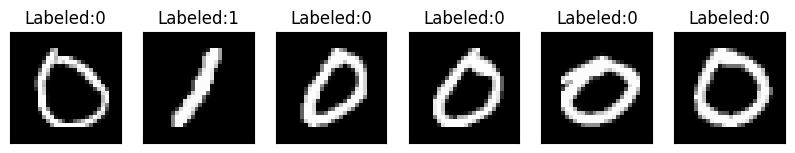

In [10]:
n_samples_show = 6
data_iter = iter(train_loader)
fig,axes=plt.subplots(nrows=1, ncols=n_samples_show,figsize=(10, 3))
while n_samples_show > 0:

  images, targets = data_iter.__next__()
  axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
  axes[n_samples_show -1].set_xticks([])
  axes[n_samples_show -1].set_yticks([])
  axes[n_samples_show - 1].set_title("Labeled:{}".format(targets.item()))

  n_samples_show -= 1

In [11]:
# Concentrating on the first 100 samples
n_samples = 50
X_train = datasets.MNIST(root='./data',train=True,download=True,transform=transforms.Compose([transforms.ToTensor()]))
# Leaving only labels 0 and 1
idx = np.append(np.where(X_train.targets ==0)[0][:n_samples],np.where(X_train.targets ==1)[0][:n_samples])
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]
train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

In [12]:
class Net(nn.Module):
  def __init__(self):
   super(Net,self).__init__()
   self.conv1 = nn.Conv2d(1,6,kernel_size=5)
   self.conv2 = nn.Conv2d(6,16,kernel_size=5)
   self.dropout = nn.Dropout2d()
   self.fcl = nn.Linear (256, 64)
   self.fc2 = nn.Linear(64, 1)
   self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'),100, np.pi / 2)
  def forward(self, x):
   x=F.relu(self.conv1(x))
   x=F.max_pool2d(x,2)
   x=F.relu(self.conv2(x))
   x=F.max_pool2d(x,2)
   x=self.dropout(x)
   x=x.view(1,-1)
   x=F.relu(self.fcl(x))
   x=self.fc2(x)
   x=self.hybrid(x)
   return torch.cat((x,-1,-x),-1)

In [13]:
model = Net()
optimizer = optim.Adam(model.parameters(),lr=0.001)
loss_func = nn.NLLLoss()
epochs = 20
loss_list = []
model.train()
for epoch in range(epochs):
  total_loss =[]
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    # Forward pass
    output = model(data)
    # Calculating loss
    loss = loss_func(output,target)
     # Backward pass
    loss.backward()
    # Optimize the weights
    optimizer.step()
    total_loss.append(loss.item())
  loss_list.append(sum(total_loss)/len(total_loss))
  print('Training [{:.0f}%]\tLoss:{:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))

NameError: name 'qiskit' is not defined

In [ ]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
correct = 0
for batch_idx,
(data, target) in enumerate(test_loader):
output = model(data)
pred = output.argmax(dim=1,
keepdim=True)
correct += pred.eq(target.view_as(pred)).sum().item()
loss = loss_func(output,
target)
total loss.append(loss.item())
print('Performance on test data:\n\tLoss:
sum(total_loss)
{:.4f}\n\tAccuracy:
{:.1£}%'.format(
/ len(total_loss),
correct / len(test_loader)
*
100)
)

In [ ]:
n_samples_show = 6
count = 0
fig,
axes = plt.subplots(nrows=1,
ncols=n_samples_show,
figsize=(10,
3))
model.eval()
with torch.no_grad():
for batch_idx, (data, target) in enumerate(test_loader):
if count == n_samples_show:
break
output = model(data)
pred = output.argmax(dim=1,
keepdim=True)
axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')
axes[count].set_xticks([])
axes[count].set_yticks([])
axes[count].set_title('Predicted {}'.format(pred.item()))
count += 1